In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Importar base de dados de treinamento

In [3]:
base = pd.read_csv('../../data/acoesPetrobras/base_treinamento.csv')

In [4]:
base[:8]

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0
5,2013-01-09,19.639999,19.870001,19.459999,19.680000,18.077084,24361100.0
6,2013-01-10,19.770000,20.049999,19.540001,19.830000,18.214869,17526200.0
7,2013-01-11,19.850000,20.040001,19.700001,19.879999,18.260794,18223600.0


In [5]:
base = base.dropna()

In [31]:
base_treinamento = base.iloc[:, 1:7].values

In [32]:
base_treinamento

array([[1.9990000e+01, 2.0209999e+01, 1.9690001e+01, 1.9690001e+01,
        1.8086271e+01, 3.0182600e+07],
       [1.9809999e+01, 2.0400000e+01, 1.9700001e+01, 2.0400000e+01,
        1.8738441e+01, 3.0552600e+07],
       [2.0330000e+01, 2.0620001e+01, 2.0170000e+01, 2.0430000e+01,
        1.8766001e+01, 3.6141000e+07],
       ...,
       [1.5990000e+01, 1.6139999e+01, 1.5980000e+01, 1.6049999e+01,
        1.6017963e+01, 2.3552200e+07],
       [1.6100000e+01, 1.6129999e+01, 1.6000000e+01, 1.6100000e+01,
        1.6067865e+01, 1.9011500e+07],
       [1.6100000e+01, 1.6100000e+01, 1.6100000e+01, 1.6100000e+01,
        1.6067865e+01, 0.0000000e+00]])

#### Normalizar os dados

In [33]:
normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)

In [34]:
normalizador_previsao = MinMaxScaler(feature_range=(0,1))
normalizador_previsao.fit_transform(base_treinamento[:,0:1])

array([[0.76501938],
       [0.7562984 ],
       [0.78149225],
       ...,
       [0.57122093],
       [0.57655039],
       [0.57655039]])

#### Formar base de dados de forma a utilizar os 90 registros anteriores para se prever o proximo valor

In [35]:
previsores = []
preco_real = []
for i in range(90, 1242):
    previsores.append(base_treinamento_normalizada[i-90:i,0:6])
    preco_real.append(base_treinamento_normalizada[i,0])

In [36]:
previsores, preco_real = np.array(previsores), np.array(preco_real)

In [37]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

#### Estrutura da Rede Neural

In [38]:
regressor = Sequential()

regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 6)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units = 1, activation = 'sigmoid'))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 10, verbose=1)
rlr = ReduceLROnPlateau(monitor = 'loss', factor=0.2, patience = 5, verbose=1)
mcp = ModelCheckpoint(filepath='pesos.h5', monitor='loss', save_best_only=True)
regressor.fit(previsores, preco_real, epochs=100, batch_size =32, callbacks = [es,rlr, mcp])

Epoch 1/100
1152/1152 [==============================] - 16s 14ms/step - loss: 0.0172 - mean_absolute_error: 0.0988
Epoch 2/100
1152/1152 [==============================] - 20s 17ms/step - loss: 0.0055 - mean_absolute_error: 0.0579
Epoch 3/100
1152/1152 [==============================] - 32s 28ms/step - loss: 0.0048 - mean_absolute_error: 0.0537
Epoch 4/100
1152/1152 [==============================] - 37s 32ms/step - loss: 0.0047 - mean_absolute_error: 0.0539
Epoch 5/100
1152/1152 [==============================] - 25s 21ms/step - loss: 0.0043 - mean_absolute_error: 0.0507
Epoch 6/100
1152/1152 [==============================] - 16s 14ms/step - loss: 0.0041 - mean_absolute_error: 0.0498
Epoch 7/100
1152/1152 [==============================] - 18s 16ms/step - loss: 0.0041 - mean_absolute_error: 0.0504
Epoch 8/100
1152/1152 [==============================] - 16s 14ms/step - loss: 0.0043 - mean_absolute_error: 0.0514
Epoch 9/100
1152/1152 [==============================] - 16s 14ms/step -

#### Base de teste

In [39]:
base_teste = pd.read_csv('../../data/acoesPetrobras/base_teste.csv')
preco_real_teste = base_teste.iloc[:,1:2].values
frames = [base, base_teste]

#### Concatenar as bases

In [40]:
base_completa = pd.concat(frames)

In [41]:
base_completa = base_completa.drop('Date', axis=1)

In [42]:
entradas = base_completa[len(base_completa)-len(base_teste)-90:].values
entradas = entradas.reshape(-1,1)

In [43]:
entradas = normalizador.transform(entradas)

In [44]:
x_teste = []
for i in range(90, 112):
    x_teste.append(entradas[i-90:i, 0:6])
x_teste = np.array(x_teste)


In [45]:
previsoes = regressor.predict(x_teste)
previsoes = normalizador_previsao.inverse_transform(previsoes)

In [49]:
previsoes.mean()

17.751333

In [50]:
preco_real_teste.mean()

17.87454563636364

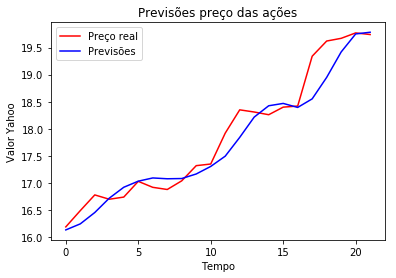

In [48]:
plt.plot(preco_real_teste, color = 'red', label = 'Preço real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
plt.title('Previsões preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.show()
